#### **This Notebook Attempts to use some Automatic Feature Selection Methods to improve performance**

Import the libraries and data.

In [1]:
import sys
sys.path.append('..')
from Cleaning_and_Evaluation import *
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GroupKFold, cross_val_score
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.inspection import permutation_importance

In [2]:
#df = pd.read_csv("../data/exosomes.raw_spectrum_1.csv")
#df = pd.read_csv("../data/exosomes.raw_spectrum_400-1800.csv")
df = pd.read_csv("../data/current_clean_spectrum.csv")
#df = pd.read_csv("../data/standard_cleaning.csv")


<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

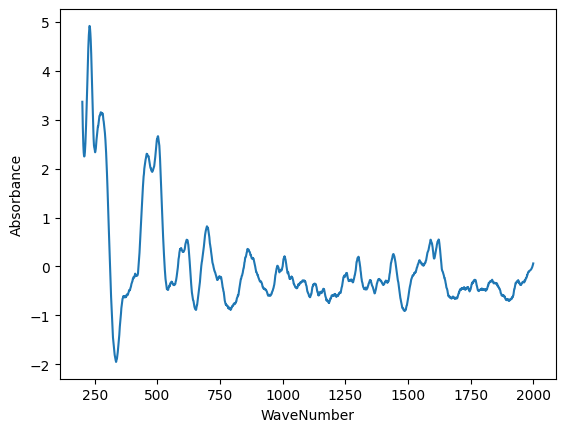

In [3]:
sample = df[df['SpecID'] == "201210-1-07"]
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)

In [4]:
et = ExtraTreesClassifier(random_state=1234)
svc = SVC(random_state=1234)

In [5]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

In [6]:
wavelength_df.head()

,200.0,200.68336,201.36674,202.05011,202.73349,203.41685,204.10023,204.7836,205.46696,206.15034,...,1995.2164,1995.8998,1996.5831,1997.2665,1997.9498,1998.6333,1999.3167,2000.0,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,2.443895,2.340851,2.246252,2.159808,2.081228,2.010222,1.946500,1.889771,1.839746,1.796132,...,-0.219738,-0.218255,-0.216545,-0.214591,-0.212375,-0.209878,-0.207084,-0.203975,201210-1,Normal
201210-1-01,2.987729,2.877140,2.771600,2.671053,2.575446,2.484723,2.398830,2.317713,2.241317,2.169588,...,0.139463,0.158756,0.178290,0.198040,0.217982,0.238089,0.258338,0.278702,201210-1,Normal
201210-1-02,1.367590,1.338989,1.309418,1.278995,1.247839,1.216070,1.183807,1.151170,1.118277,1.085248,...,0.993536,1.009665,1.021793,1.029665,1.033029,1.031629,1.025214,1.013529,201210-1,Normal
201210-1-03,4.494705,4.659871,4.799524,4.914824,5.006931,5.077004,5.126202,5.155685,5.166612,5.160143,...,-0.483049,-0.484923,-0.487230,-0.489997,-0.493249,-0.497011,-0.501307,-0.506165,201210-1,Normal
201210-1-04,1.399465,1.357917,1.318500,1.281168,1.245880,1.212592,1.181260,1.151841,1.124292,1.098568,...,-0.376922,-0.365798,-0.353721,-0.340652,-0.326552,-0.311383,-0.295106,-0.277681,201210-1,Normal


Show the performance of the current approach.

In [7]:
evaluate_model(wavelength_df, et)

/home/eddie/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ExtraTreesClassifier Cross-Validation Accuracy: 0.6191 +/- 0.1216
ExtraTreesClassifier Cross-Validation Precision: 0.6317 +/- 0.1340
ExtraTreesClassifier Cross-Validation Recall: 0.6358 +/- 0.1626
ExtraTreesClassifier Cross-Validation F1-Score: 0.5968 +/- 0.1424


In [8]:
evaluate_model(wavelength_df, svc)

/home/eddie/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVC Cross-Validation Accuracy: 0.5084 +/- 0.1067
SVC Cross-Validation Precision: 0.5342 +/- 0.1099
SVC Cross-Validation Recall: 0.5258 +/- 0.1414
SVC Cross-Validation F1-Score: 0.4871 +/- 0.1157


---

##### **Chi-Squared**

In [9]:
# Set the Surfaces as groups
groups = wavelength_df['SurID']
X = wavelength_df.drop(['Status', 'SurID'], axis=1)
y = wavelength_df['Status']


num_features = int(X.shape[1] * 0.1)

# Pipeline for scaling, feature selection, and classifier
pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('feature_selection', SelectKBest(chi2, k=num_features)),
    ('classifier', ExtraTreesClassifier(random_state=1234))
])

# Using GroupKFold for classification tasks
cv = GroupKFold(n_splits=10)

# Getting cross-validation scores using the pipeline
scores = cross_val_score(pipe, X, y, cv=cv, scoring='accuracy', groups=groups, n_jobs=-1)

# Displaying the results
print(f'Pipeline Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

Pipeline Cross-Validation Accuracy: 0.5823 +/- 0.1042


In [10]:
# Set the Surfaces as groups
groups = wavelength_df['SurID']
X = wavelength_df.drop(['Status', 'SurID'], axis=1)
y = wavelength_df['Status']

num_features = int(X.shape[1] * 0.1)

# Pipeline for scaling, feature selection, and classifier
pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('feature_selection', SelectKBest(chi2, k=num_features)),
    ('classifier', SVC(random_state=1234))
])

# Using GroupKFold for classification tasks
cv = GroupKFold(n_splits=10)

# Getting cross-validation scores using the pipeline
scores = cross_val_score(pipe, X, y, cv=cv, scoring='accuracy', groups=groups, n_jobs=-1)

# Displaying the results
print(f'Pipeline Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

Pipeline Cross-Validation Accuracy: 0.4996 +/- 0.1083


---

##### **Mutual Information**

In [11]:
# Set the Surfaces as groups
groups = wavelength_df['SurID']
X = wavelength_df.drop(['Status', 'SurID'], axis=1)
y = wavelength_df['Status']

# Define the number of features to keep
num_features = int(X.shape[1] * 0.1)
# num_features = int(250)

# Create a pipeline with feature selection and classifier
pipeline = Pipeline([
    ('feature_selection', SelectKBest(mutual_info_classif, k=num_features)),
    ('classifier', ExtraTreesClassifier(random_state=1234))
])

# Using GroupKFold for classification tasks
cv = GroupKFold(n_splits=10)

# Get cross-validation scores
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy', groups=groups, n_jobs=-1)

# Displaying the results
print(f'Pipeline Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

Pipeline Cross-Validation Accuracy: 0.5678 +/- 0.1009


In [12]:
# Set the Surfaces as groups
groups = wavelength_df['SurID']
X = wavelength_df.drop(['Status', 'SurID'], axis=1)
y = wavelength_df['Status']

# Define the number of features to keep
num_features = int(X.shape[1] * 0.1)
#num_features = int(250)

# Create a pipeline with feature selection and classifier
pipeline = Pipeline([
    ('feature_selection', SelectKBest(mutual_info_classif, k=num_features)),
    ('classifier', SVC(random_state=1234))
])

# Using GroupKFold for classification tasks
cv = GroupKFold(n_splits=10)

# Get cross-validation scores
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy', groups=groups, n_jobs=-1)

# Displaying the results
print(f'Pipeline Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

Pipeline Cross-Validation Accuracy: 0.4948 +/- 0.1184


---

##### **Correlation Coefficients**

In [13]:
# Set the Surfaces as groups
groups = wavelength_df['SurID']
X = wavelength_df.drop(['Status', 'SurID'], axis=1)
y = wavelength_df['Status']

# Define the number of features to keep
num_features = int(X.shape[1] * 0.1)
#num_features = 250

# Create a pipeline with feature selection and classifier
pipeline = Pipeline([
    ('feature_selection', SelectKBest(f_classif, k=num_features)),
    ('classifier', ExtraTreesClassifier(random_state=1234))
])

# Using GroupKFold for classification tasks
cv = GroupKFold(n_splits=10)

# Get cross-validation scores
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy', groups=groups, n_jobs=-1)

# Displaying the results
print(f'Pipeline Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

Pipeline Cross-Validation Accuracy: 0.5360 +/- 0.0788


In [14]:
# Set the Surfaces as groups
groups = wavelength_df['SurID']
X = wavelength_df.drop(['Status', 'SurID'], axis=1)
y = wavelength_df['Status']

# Define the number of features you want to keep
num_features = int(X.shape[1] * 0.1)
#num_features = 250

# Create a pipeline with feature selection and classifier
pipeline = Pipeline([
    ('feature_selection', SelectKBest(f_classif, k=num_features)),
    ('classifier', SVC(random_state=1234))
])

# Using GroupKFold for classification tasks
cv = GroupKFold(n_splits=10)

# Get cross-validation scores
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy', groups=groups, n_jobs=-1)

# Displaying the results
print(f'Pipeline Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

Pipeline Cross-Validation Accuracy: 0.4626 +/- 0.0909


##### **Fisher Score Feature Selection**

In [15]:
def evaluate_extra_trees_with_fisher_score(df, num_features):
    
    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Feature Selection with Fisher Score
    selector = SelectKBest(score_func=f_classif, k=num_features)
    X_selected = selector.fit_transform(X, y)

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)
    
    # Getting cross-validation scores
    scores = cross_val_score(et, X_selected, y, cv=cv, scoring='accuracy', groups=groups, n_jobs=-1)
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')


In [16]:
evaluate_extra_trees_with_fisher_score(wavelength_df, num_features=111)

ExtraTreesClassifier Cross-Validation Accuracy: 0.4392 +/- 0.1154
